# Workshop 2 - Implementation
    
In this notebook you will continue to implement the matrix method and check it with some sanity checks.

> ### Task 0
>
> Check whether your implementation of last week was correct using the provided solution

In [1]:
import numpy as np
import matrixmethod as mm
%config InlineBackend.figure_formats = ['svg']

%load_ext autoreload
%autoreload 2

## 1. The Node class
The `Node` class from last week is unchanged and complete

## 2. The Element class

The implementation is incomplete:
- The function `add_distributed_load` should compute the equivalent load vector for a constant load $q$ and moves those loads to the nodes belonging to the element. Remember to use the `add_load` function of the `Node` class to store the equivalent loads (remember we have two nodes per element). Also keep local/global transformations in mind and store `self.q = q` for later use;
- The function `bending_moments` receives the nodal displacements of the element in the global coordinate system (`u_global`) and uses it to compute the value of the bending moment at `num_points` equally-spaced points along the element length. Keep local/global transformations in mind and use the ODE approach in SymPy / Maple / pen and paper to compute an expression for $M$. Do the same for for $w$ in the function `full_displacement`.

> ### Task 2.1
>
> Add the missing pieces to the code, before you perform the checks below.

> ### Task 2.2
>
> Having made your implementations, it is now time to verify the first addition of your code with a simple sanity check. We would like to solve the following simply-supported beam:
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/ssbeam.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Use the code blocks below to set up this problem. After you've added the load, print the element using `print(YOUR ELEMENT)`. Do the shown values for the nodal loads correspond with what you'd expect?

In [3]:
EI = 1000
q  = 10
L  = 1

mm.Node.clear()
mm.Element.clear()

node1 = mm.Node (0,0)
node2 = mm.Node (L,0)

elem = mm.Element ( node1, node2 )

section = {}
section['EI'] = EI

elem.set_section (section)

elem.add_distributed_load([0,10])

In [4]:
print(elem)

Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[ 0.          5.         -0.83333333])
with node #2:
 This node has:
 - x coordinate=1,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[0.         5.         0.83333333])


> - The vertical forces correspond to the solution from [the book](https://ciem5000-2025.github.io/book/lecture2/element_loads.html) $\cfrac{1}{2}qL=\cfrac{1}{2}\cdot 10 \cdot 1=5$
> - The moments correspond to the solution from the [the book](https://ciem5000-2025.github.io/book/lecture2/element_loads.html) $\cfrac{1}{12}qL^2=\cfrac{1}{12}\cdot 10 \cdot 1^2 \approx 0.833$

> ### Task 2.3
>  Now solve the nodal displacements. Once you are done, compare the rotation at the right end of the beam. Does it match the solution you already know?

In [5]:
con = mm.Constrainer()

con.fix_dof (node1,0)
con.fix_dof (node1,1)
con.fix_dof (node2,1)
print(con)

global_k = elem.stiffness()
global_f = np.zeros (6)

global_f[0:3] = node1.p
global_f[3:6] = node2.p

Kc, Fc = con.constrain ( global_k, global_f )
u_free = np.matmul ( np.linalg.inv(Kc), Fc )
print(u_free)

This constrainer has constrained the degrees of freedom: [0, 1, 4] with corresponding constrained values: [0, 0, 0])
[-0.00041667  0.          0.00041667]


> The rotations corresponds with the forget-me-not solution $\cfrac{qL^3}{24\cdot EI} = \cfrac{10 \cdot 1^3}{24\cdot 1000} \approx 0.0004166$

> ### Task 2.4
> Calculate the bending moment at midspan and plot the moment distribution using `plot_moment_diagram`. Do the values and shape match with what you'd expect?

[-1.48029737e-16  1.25000000e+00 -1.48029737e-16]


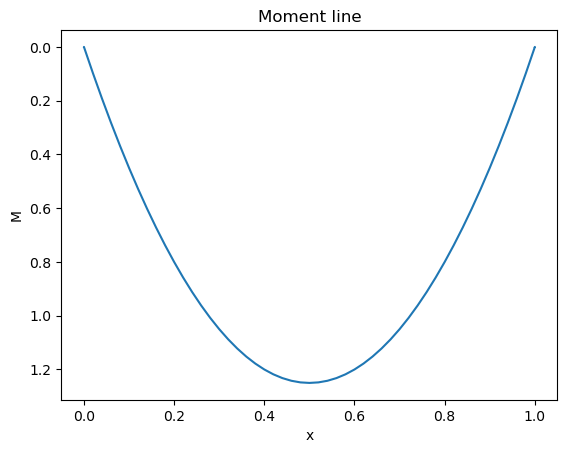

In [6]:
u_elem = con.full_disp(u_free)[elem.global_dofs()] #keep this line
moments = elem.bending_moments(u_elem,3)
print(moments)
elem.plot_moment_diagram(u_elem,num_points=51)

> - The moment corresponds with the well known solution $\cfrac{1}{8}qL^2=\cfrac{1}{8}\cdot 10 \cdot 1^2 = 1.25$
> - The shape is parabolic, as expected.

> ### Task 2.5
> Calculate the deflection at midspan and plot the deflected structure using `plot_displaced`. Do the values and shape match with what you'd expect?

(array([0., 0., 0.]), array([0.        , 0.00013021, 0.        ]))


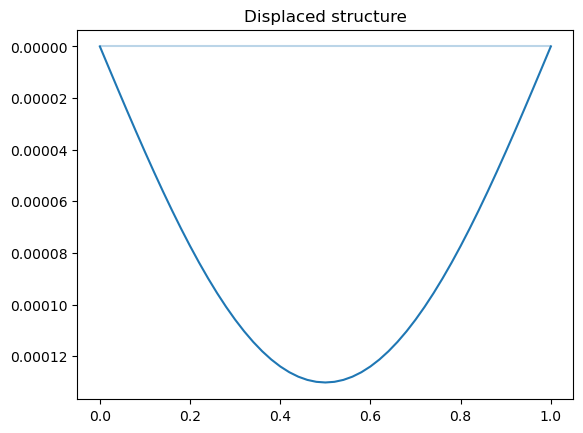

In [7]:
deflections = elem.full_displacement(u_elem,3)
print(deflections)
elem.plot_displaced(u_elem,num_points=51,global_c=False)

> - The deflection corresponds with the forget-me-not solution $\cfrac{5}{384} \cfrac{qL^4}{EI}=\cfrac{5}{384} \cfrac{10 \cdot 1^4}{1000} \approx 0.0001302$
> - The shape of the deflection is a 4th order polynomial, as expected.

## 3. The Constrainer class

We're going to expand our Constrainer class, but the implementation is incomplete:
- The constrainer class should be able to handle non-zero boundary conditions too. `constrain` should be adapted to do so + the docstring of the class itself. Furthermore, the assert statement of `fix_dof` should be removed.
- The function `support_reactions` is incomplete. Since the constrainer is always first going to get `constrain` called, here we already have access to `self.free_dofs`. Together with `self.cons_dofs`, you should have all you need to compute reactions. Note that `f` is also passed as argument. Make sure you take into account the contribution of equivalent element loads that go directly into the supports without deforming the structure.

> ### Task 3.1
>
> Add the missing pieces to the code and docstring, before you perform the checks below.

> ### Task 3.2
>
> We're going to verify our implementation. Therefore, we're going to solve an extension bar, supported at both ends, with a load $q$.
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/sanitycheck_3.2.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Can you say on beforehand what will be the displacements? And what will be the support reactions?
> Use the code blocks below to set up and solve this problem and check the required quantities to make sure your implementation is correct.

> - The displacements will be zero, as everything is fixed
> - The support reactions should be each $\cfrac{1}{2}qL = \cfrac{1}{2}\cdot 10 \cdot 1 = 5$ to the left

In [9]:
EA = 1000
q = 10
L  = 1

mm.Node.clear()
mm.Element.clear()

node1 = mm.Node (0,0)
node2 = mm.Node (L,0)

elem = mm.Element ( node1, node2 )

section = {}
section['EA'] = EA

elem.set_section (section)
elem.add_distributed_load([q,0])
print(elem)

con = mm.Constrainer()

con.fix_node (node1)
con.fix_node (node2)

print(con)

global_k = elem.stiffness()
global_f = np.zeros (6)

global_f[0:3] = node1.p
global_f[3:6] = node2.p

Kc, Fc = con.constrain ( global_k, global_f )
u_free = np.matmul ( np.linalg.inv(Kc), Fc )
print(u_free)

print(con.support_reactions(global_k,u_free,global_f))

Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[5. 0. 0.])
with node #2:
 This node has:
 - x coordinate=1,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[5. 0. 0.])
This constrainer has constrained the degrees of freedom: [0, 1, 2, 3, 4, 5] with corresponding constrained values: [0, 0, 0, 0, 0, 0])
[]
[-5.  0.  0. -5.  0.  0.]


> ### Task 3.3
>
> Again, we're going to verify our implementation. Therefore, we're going solve a beam, with a load $F$ and support displacement $\bar w$ for the right support.
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/sanitycheck_3.3_new.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Use the code blocks below to set up and solve this problem and check the required quantities to make sure your implementation is correct.

In [10]:
EI = 1000
F  = 10
L  = 1
w_B = 0.1

mm.Node.clear()
mm.Element.clear()

node1 = mm.Node (0,0)
node2 = mm.Node (L,0)
node2.add_load([0,F,0])

elem = mm.Element ( node1, node2 )

section = {}
section['EI'] = EI

elem.set_section (section)

print(elem)

con = mm.Constrainer()

con.fix_node (node1)
con.fix_dof (node2,1,w_B)

print(con)

global_k = elem.stiffness()
global_f = np.zeros (6)

global_f[0:3] = node1.p
global_f[3:6] = node2.p

Kc, Fc = con.constrain ( global_k, global_f )
u_free = np.matmul ( np.linalg.inv(Kc), Fc )
print(u_free)

print(con.support_reactions(global_k,u_free,global_f))

Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[0. 0. 0.])
with node #2:
 This node has:
 - x coordinate=1,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[ 0. 10.  0.])
This constrainer has constrained the degrees of freedom: [0, 1, 2, 4] with corresponding constrained values: [0, 0, 0, 0.1])
[ 0.   -0.15]
[   0. -300.  300.  290.]


> - The rotation at B corresponds with the forget-me-not solution $\cfrac{3}{2} \cfrac{w_B}{L}=\cfrac{3}{2} \cdot \cfrac{0.1}{1} = 0.15$
> - The moment at A corresponds with the ODE solution of $\cfrac{3  EI}{L^2 w_B}=\cfrac{3 \cdot 1000}{1^2 \cdot 0.1} = 300$
> - The vertical support reaction at A corresponds with the ODE solution of $\cfrac{3  EI}{L^3 w_B}=\cfrac{3 \cdot 1000}{1^3 \cdot 0.1} = 300$
> - The vertical support reaction at B corresponds with the ODE solution of $\cfrac{3  EI}{L^3 w_B}=\cfrac{3 \cdot 1000}{1^3 \cdot 0.1} = 300$ minus the load $F = 10$. The $10$ and $290$ together are equal to the reaction force of $300$

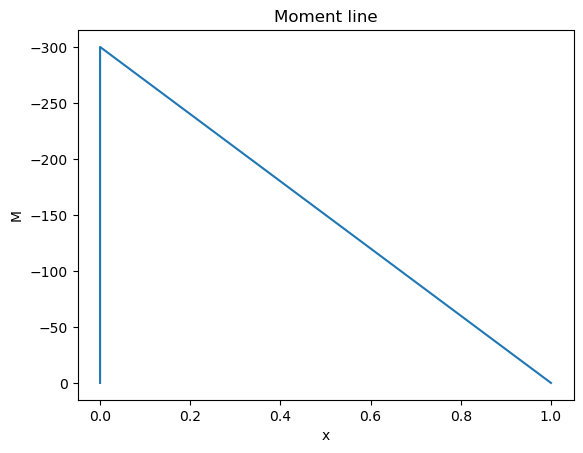

In [11]:
u_elem = con.full_disp(u_free)[elem.global_dofs()] #keep this line
elem.plot_moment_diagram(u_elem,num_points=51)

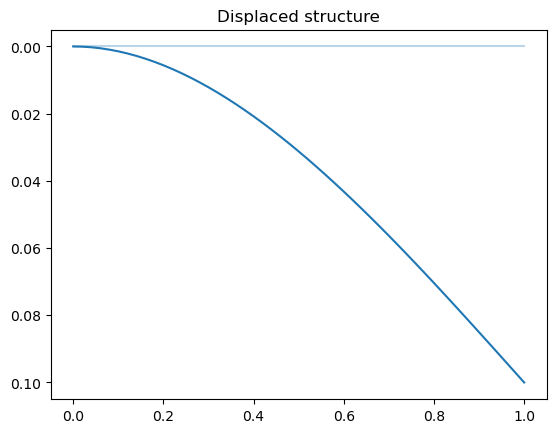

In [12]:
deflections = elem.full_displacement(u_elem,3)
elem.plot_displaced(u_elem,num_points=51,global_c=False)

> The moment line and displacement line look as expected.